In [1]:
# The MIT License (MIT) Copyright (c) 2023 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/20_Transformer_img_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer

- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

In [2]:
import torch
import torchvision
import PIL
import pathlib
import random

torch.__version__

'2.0.1+cu117'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

- Download images:

In [4]:
#!wget https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz?download=1

In [5]:
#!tar -xf 'CUB_200_2011.tgz?download=1'

- Download textual descriptions from https://github.com/reedscot/cvpr2016 and https://github.com/savya08/StackGAN
- Textual descriptions in text_c10 dir

In [6]:
import os

# Base dirs
image_dir = './CUB_200_2011/images/'
text_dir = './text_c10/'

file_tuples = [] 

for root, dirs, files in os.walk(image_dir):
    for file in files:
        image_path = os.path.join(root, file)
        text_path = os.path.join(text_dir, os.path.relpath(image_path, image_dir).replace('.jpg', '.txt'))
        
        # Read file lines
        with open(text_path, 'r') as text_file:
            lines = text_file.readlines()
        
        # Add line as tuple
        for line in lines:
            file_tuples.append((image_path, line.strip()))
            
random.Random(77).shuffle(file_tuples)
for file_tuple in file_tuples[:2]:
    print(file_tuple)

('./CUB_200_2011/images/062.Herring_Gull/Herring_Gull_0039_46420.jpg', 'this bird has an all white body except for a black tipped tail and an orange bill.')
('./CUB_200_2011/images/068.Ruby_throated_Hummingbird/Ruby_Throated_Hummingbird_0126_57371.jpg', 'this small bird has a very long thin beak with a body and wing coloring of green, brown and white.')


In [7]:
len(file_tuples)

117880

In [8]:
num_val_samples = int(0.1 * len(file_tuples))
train_tuples = file_tuples[num_val_samples:]
val_tuples = file_tuples[:num_val_samples]
len(train_tuples), len(val_tuples)

(106092, 11788)

## 2.- Pipeline

- Create vocabulary and tokenizer.

In [9]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
from collections import Counter

In [10]:
tokenizer = get_tokenizer('basic_english')

In [11]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [12]:
vocab_size = len(vocab)
vocab_size

6513

In [13]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

- Reduce dataset size for simplicity

In [14]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor([vocab[token] for token in tokenizer(y)],
                                dtype=torch.long)

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))
    return data

train_data = data_process(train_tuples[:30000])
val_data = data_process(val_tuples[:1000])
len(train_data), len(val_data)

(29706, 990)

In [15]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from PIL import Image

transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(torch.cat([torch.tensor([BOS_IDX]),
                            y_item, 
                            torch.tensor([EOS_IDX])], dim=0))

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    
    # Desired padding length and padding value
    # Calculate the amount of padding required
    padding = (0, maxlen - y.size(1) + 1)  # (left, right)
    
    # Pad the sequence
    y = torch.nn.functional.pad(y, padding, value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]


train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch, 
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch, 
                    num_workers=4, pin_memory=True)

In [16]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 36]), torch.Size([64, 36]))

In [17]:
import matplotlib.pyplot as plt

In [18]:
def plot_img(enc_batch, target_batch, idx=0):
    image_array = enc_batch[idx].permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[target_batch[idx][_]] for _ in range(maxlen - 1)]
    ).replace("<pad>", "")
    
    fig = plt.figure(figsize=(2, 2))  
    
    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(image_text)  

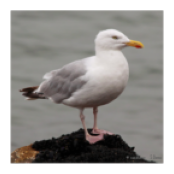

this bird has an all white body except for a black tipped tail and an orange bill . <eos>                


In [19]:
plot_img(enc_batch, target_batch)

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [20]:
import torch.nn as nn
from torch import optim
import time

In [21]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [22]:
class CNN(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(CNN, self).__init__()
        self.filters = filters
        self.down_block = nn.Sequential(
            nn.Conv2d(3, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
            DownBlockComp(filters // 8, filters // 4),
            DownBlockComp(filters // 4, filters // 2),
            DownBlockComp(filters // 2, filters),
            DownBlockComp(filters, filters),
            nn.Conv2d(filters, filters, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.down_block(x).view(B, -1, self.filters)
        return x
    
    
discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 36, 256])

### Transformer block

In [23]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:  
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))
        
        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [24]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context) 
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [25]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 36]), torch.Size([64, 36]))

### Transformer

In [26]:
class Transformer(nn.Module):
    def __init__(self, dim, vocab_size, maxlen, depth=3, 
                 mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, maxlen, dim))

        self.decoder = nn.ModuleList()
        for i in range(self.depth):
            self.decoder.append(DecoderBlock(dim, maxlen))

        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]

        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x

    
model_dim = 64
mlp_dim = 128
depth = 3

transformer = Transformer(dim=model_dim, vocab_size=vocab_size, 
          maxlen=maxlen, depth=depth, mlp_dim=mlp_dim)
output = transformer(dec_batch, enc_batch)
output.shape, target_batch.shape

(torch.Size([64, 36, 6513]), torch.Size([64, 36]))

## 4.- Training

In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (embedding): Embedding(6513, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): GE

In [28]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [29]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [30]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]      
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            idx = torch.cat((idx, idx_next), dim=1)

        txt = " ".join(
                    [vocab.get_itos()[idx[0, _]] for _ in range(maxlen)]
                )
    print(f'Generated text: {txt.replace("<bos>", "").replace("<eos>", "")})')
        

generate(transformer, enc_batch[0], device, maxlen)

Generated text:  tan/orange neutrally maybe contrastis whoe variances accompany inverse-v white/ birght belly/abdomen creepy stares apple part molar versus whaite mottled-grey sings jay until yellow/brown black/dark identify move everything black/gray mixes reddish-yellow aare glowing gets podge rows)


In [31]:
epochs = 16

for epoch in range(epochs):
    train(transformer, device, train_loader, optimizer, epoch)
    generate(transformer, enc_batch[0], device, maxlen)


Time for epoch 0 is 16.8956 sec Train loss: 2.8894
Generated text:  this bird has a brown crown , a white belly and a brown crown .  as well as well as well as a white belly .  black and a white and a brown)

Time for epoch 1 is 16.7304 sec Train loss: 2.1362
Generated text:  this bird has a white belly and breast with a short pointy bill .  black and white wingbars .  and a white eye .  long tail .  .  as well)

Time for epoch 2 is 17.1050 sec Train loss: 2.0020
Generated text:  this bird has a white belly and breast , with a black crown and a black bill .  .  .  .  .  a black and a white eyering . )

Time for epoch 3 is 17.3143 sec Train loss: 1.9234
Generated text:  this bird has a white belly and breast with a black crown and wings .  and tail .  with a long , and pointy beak .  .  .  orange .)

Time for epoch 4 is 17.1723 sec Train loss: 1.8649
Generated text:  this bird has a white belly and breast , with a black crown and a long pointy bill .  .  .  .  .  .  .  white . )

Time 

- Test the model on validation images.

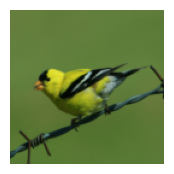

this bird is primarily green and yellow with black wings and a black crown . <eos>                   
Generated text:  this bird has a yellow belly and breast with a black crown and short pointy bill .  and secondary feathers .  is black .  white .  and white .  .)


In [32]:
idx = 2
plot_img(enc_batch, target_batch, idx=idx)
generate(transformer, enc_batch[idx], device, maxlen)

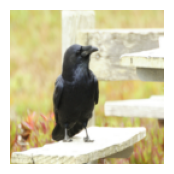

a medium sized black bird with a very large bill <eos>                        
Generated text:  this bird has a black crown , a black bill , and a black breast  and belly  .  feathers .  white tips .  white tips .  eyes . )


In [33]:
idx = 16
plot_img(enc_batch, target_batch, idx=idx)
generate(transformer, enc_batch[idx], device, maxlen)